In [ ]:
pip install xverse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

Sun Sep 18 03:00:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from xverse.transformer import MonotonicBinning
from xverse.transformer import WOE

import pylab as pl

import xgboost as xgb
import lightgbm as lgb

import gc
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import database
df = pd.read_parquet('/content/drive/MyDrive/amex_default_group.parquet')

In [ ]:
df.head(5)

,customer_ID,target,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.933824,0.230769,0.012007,1.005086,0.004509,0.113215,0.0,0.006456,...,2.0,1.0,0.0,5.0,0.0,2.0,0.0,0.0,-1.0,6.0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.899820,7.153846,0.025654,0.991083,0.006246,0.120578,0.0,0.005663,...,2.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,-1.0,6.0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.878454,0.000000,0.004386,0.815677,0.006621,NaN,0.0,0.005493,...,1.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0,-1.0,6.0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.598969,1.538462,0.059876,0.955264,0.005665,0.247750,0.0,0.006423,...,2.0,1.0,0.0,5.0,0.0,2.0,3.0,0.0,-1.0,3.0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.891679,0.000000,0.005941,0.814543,0.004180,0.173102,0.0,0.005088,...,1.0,1.0,0.0,5.0,0.0,2.0,3.0,0.0,1.0,6.0


In [ ]:
cat_vars = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [ ]:
pd.DataFrame(df.isnull().sum()/len(df) * 100)

,0
customer_ID,0.000000
target,0.000000
P_2,0.530384
D_39,0.000000
B_1,0.000000
...,...
D_126,0.000000
D_63,0.000000
D_64,0.000000
D_66,0.000000


In [ ]:
df.drop('customer_ID', axis = 1, inplace = True)
df.shape

(458913, 168)

# Handling categorical variables

In [ ]:
clf = MonotonicBinning()
clf.fit(df[cat_vars], df.target)
output_bins = clf.bins


In [ ]:
X1 = clf.transform(df[cat_vars])

In [ ]:
clf1 = WOE()
clf1.fit(X1, df.target)

X2 = clf1.transform(X1)

In [ ]:
df[cat_vars] = X2.copy()

## Split dataset
Data is divided into three sets: training (75%), validation (15%), and testing (10%). 

In [ ]:
l = df.shape[0]
i = np.arange(l)
np.random.shuffle(i)

In [ ]:
i_75 = round(l * 0.75)
i_90 = round(l * 0.90)
X_data = df.drop(columns = ['target']).copy()
y_data = df['target'].copy()
X_train, X_val, X_test = X_data.iloc[:i_75,], X_data.iloc[i_75: i_90,], X_data.iloc[i_90:,] 
y_train, y_val, y_test = y_data.iloc[:i_75,], y_data.iloc[i_75: i_90,], y_data.iloc[i_90:,]

In [ ]:
print(f'The shape of the train set is: {X_train.shape}')
print(f'The shape of the validation set is: {X_val.shape}')
print(f'The shape of the test set is: {X_test.shape}')

The shape of the train set is: (344185, 167)
The shape of the validation set is: (68837, 167)
The shape of the test set is: (45891, 167)


# Performance

Firstly, let's create a function that evaluates the performance of the models.

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"] = (12,8)
%matplotlib inline

def mod_perforance(y_obs, y_prob):

  fpr, tpr, thresholds = roc_curve(y_obs, y_prob)
  roc_auc = auc(fpr, tpr)
  print("Area under the ROC curve : %f" % roc_auc)
  print()
  print()

  i = np.arange(len(tpr)) # index for df
  roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
  results = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
  print(results)
  print()

  y_pred = np.where(y_prob > results.iloc[:,4].values[0], 1, 0)

  print(classification_report(y_obs, y_pred))
  print()
  
  # Plot tpr vs 1-fpr
  fig, ax = pl.subplots(figsize=(12, 8))
  pl.plot(roc['tpr'])
  pl.plot(roc['1-fpr'], color = 'red')
  pl.xlabel('1-False Positive Rate')
  pl.ylabel('True Positive Rate')
  pl.title('Receiver operating characteristic')
  plt.show()
  print()

  # Confusion matrix
  plt.figure(figsize = (12,8))
  cm = pd.crosstab(y_obs, y_pred)
  sns.set(font_scale = 1.5)
  ax = sns.heatmap(cm, annot=True, cmap='Oranges',  fmt='d', linewidths=1)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title('Confusion matrix')
  plt.show()
  print()
  
  # ROC CURVE
  plt.figure(figsize = (12,8))
  plt.plot(fpr,tpr,label="AUC="+str(round(roc_auc,2)), color='darkorange')
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()
  print()
  
  # Distribution of probabilities
  plt.figure(figsize = (12,8))
  plt.hist(y_prob[y_test == 0], bins = 50, alpha=0.5, label='No Default')  
  plt.hist(y_prob[y_test == 1], bins = 50, alpha=0.5, label='Default')
  plt.title('Histogram of probabilities')
  plt.legend(loc='upper right')
  plt.show()

  # Boxplot distributions
  plt.figure(figsize = (12,8))
  sns.boxplot(x = y_obs, y = y_prob).set(
            xlabel = 'Default', 
            ylabel = 'Probs')
  plt.title('Boxplot of each category')
  plt.show()
  

 # Models: XGBoost

In [ ]:
mod1 = xgb.XGBClassifier(n_estimators = 200,
                       max_depth = 8, 
                       learning_rate = 0.3,
                       colsample_bytree = 0.8,
                       objective= 'binary:logistic',
                       reg_lambda = 0,
                       reg_alpha = 0,
                       gamma = 0,
                       scale_pos_weight = 4, 
                       eval_metric = 'auc')
mod1.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds = 50, verbose = 10)

[0]	validation_0-auc:0.934199	validation_1-auc:0.930537
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[10]	validation_0-auc:0.955142	validation_1-auc:0.946662
[20]	validation_0-auc:0.96291	validation_1-auc:0.949213
[30]	validation_0-auc:0.968156	validation_1-auc:0.949768
[40]	validation_0-auc:0.971832	validation_1-auc:0.949948
[50]	validation_0-auc:0.974933	validation_1-auc:0.949813
[60]	validation_0-auc:0.977309	validation_1-auc:0.949672
[70]	validation_0-auc:0.979115	validation_1-auc:0.949616
[80]	validation_0-auc:0.981019	validation_1-auc:0.949477
[90]	validation_0-auc:0.982537	validation_1-auc:0.949212
Stopping. Best iteration:
[40]	validation_0-auc:0.971832	validation_1-auc:0.949948



XGBClassifier(colsample_bytree=0.8, eval_metric='auc', learning_rate=0.3,
              max_depth=8, n_estimators=200, reg_lambda=0, scale_pos_weight=4)

Area under the ROC curve : 0.950096


           fpr       tpr     1-fpr        tf  thresholds
4827  0.120597  0.879344  0.879403 -0.000059    0.627969

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     34122
           1       0.72      0.88      0.79     11769

    accuracy                           0.88     45891
   macro avg       0.84      0.88      0.85     45891
weighted avg       0.89      0.88      0.88     45891




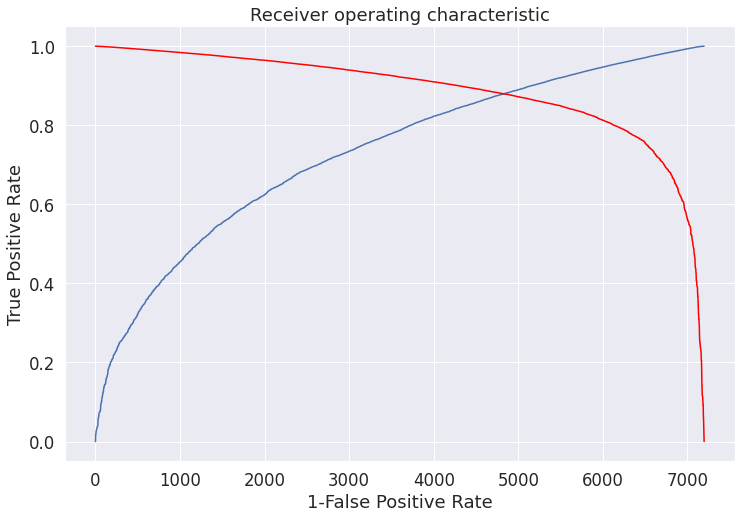

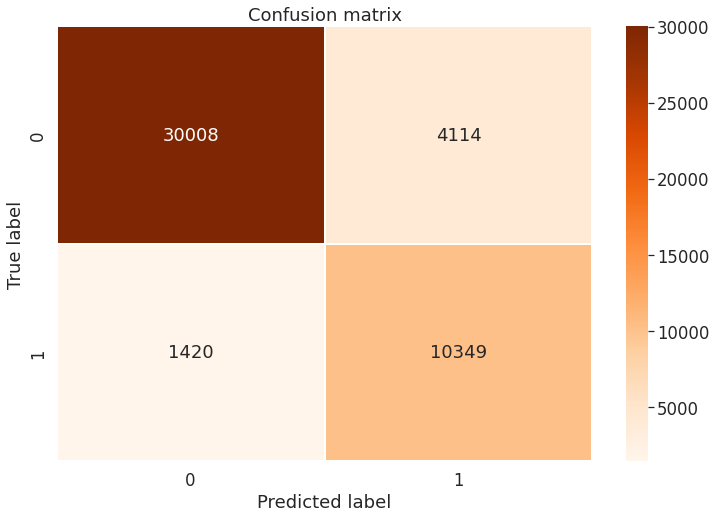

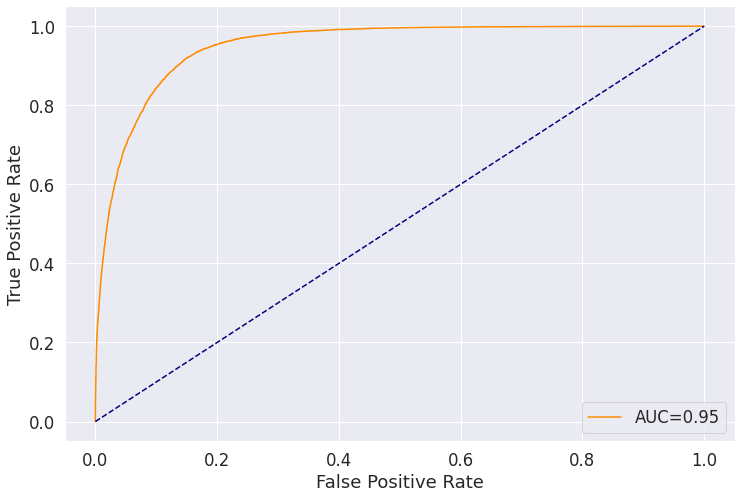

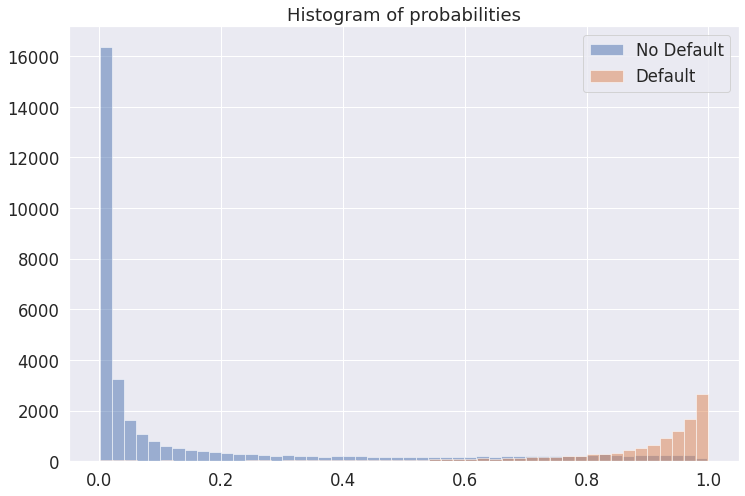

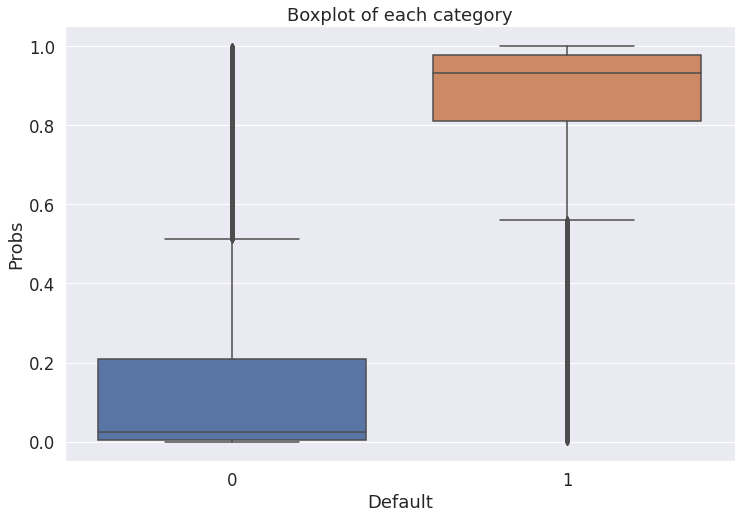

In [ ]:
mod_perforance(y_test, mod1.predict_proba(X_test)[:,1])

In [ ]:
joblib.dump(mod1, "xgb_mod1.sav")

['xgb_mod1.sav']

## Model 2

In [ ]:
mod2 = xgb.XGBClassifier(n_estimators = 200,
                       max_depth = 7, 
                       learning_rate = 0.3,
                       colsample_bytree = 0.9,
                       objective= 'binary:logistic',
                       reg_lambda = 0,
                       reg_alpha = 0,
                       gamma = 10,
                       scale_pos_weight = 5, 
                       eval_metric = 'auc')
mod2.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds = 50, verbose = 10)

[0]	validation_0-auc:0.930211	validation_1-auc:0.928514
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[10]	validation_0-auc:0.950154	validation_1-auc:0.945761
[20]	validation_0-auc:0.957353	validation_1-auc:0.949401
[30]	validation_0-auc:0.961269	validation_1-auc:0.950529
[40]	validation_0-auc:0.964322	validation_1-auc:0.950894
[50]	validation_0-auc:0.966421	validation_1-auc:0.950911
[60]	validation_0-auc:0.968769	validation_1-auc:0.950982
[70]	validation_0-auc:0.970572	validation_1-auc:0.950877
[80]	validation_0-auc:0.971886	validation_1-auc:0.950915
[90]	validation_0-auc:0.973579	validation_1-auc:0.950659
[100]	validation_0-auc:0.974686	validation_1-auc:0.950527
[110]	validation_0-auc:0.975817	validation_1-auc:0.950407
Stopping. Best iteration:
[64]	validation_0-auc:0.969487	validation_1-auc:0.951026



XGBClassifier(colsample_bytree=0.9, eval_metric='auc', gamma=10,
              learning_rate=0.3, max_depth=7, n_estimators=200, reg_lambda=0,
              scale_pos_weight=5)

Area under the ROC curve : 0.950614


           fpr       tpr     1-fpr        tf  thresholds
4884  0.120538  0.879429  0.879462 -0.000033    0.678836

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     34122
           1       0.72      0.88      0.79     11769

    accuracy                           0.88     45891
   macro avg       0.84      0.88      0.85     45891
weighted avg       0.89      0.88      0.88     45891




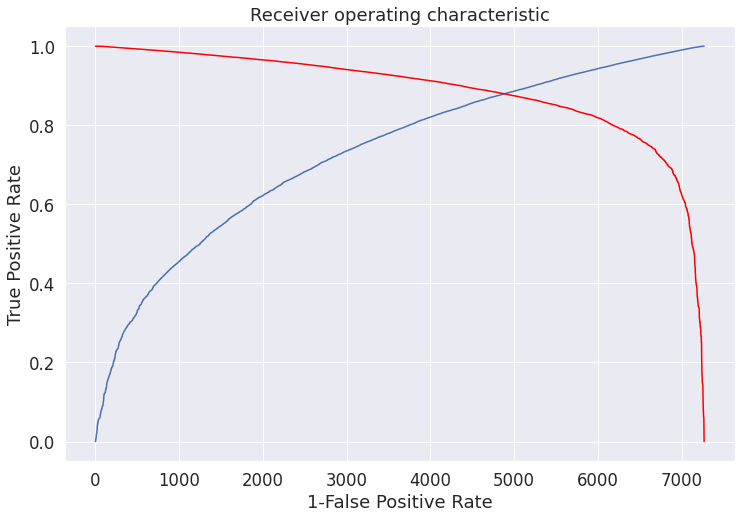

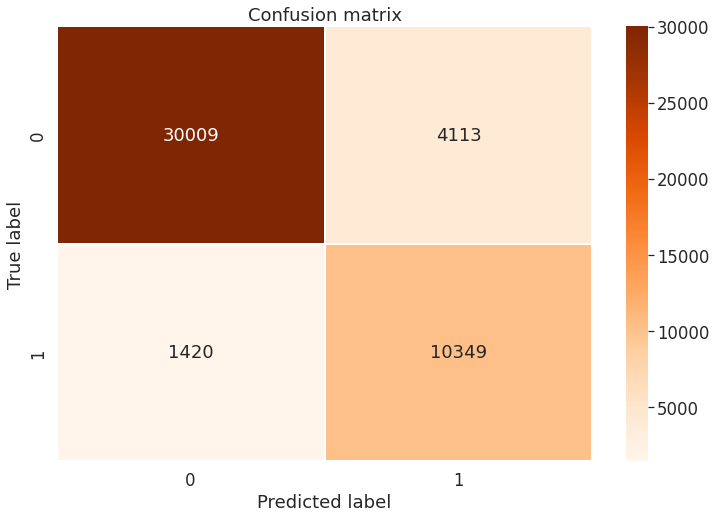

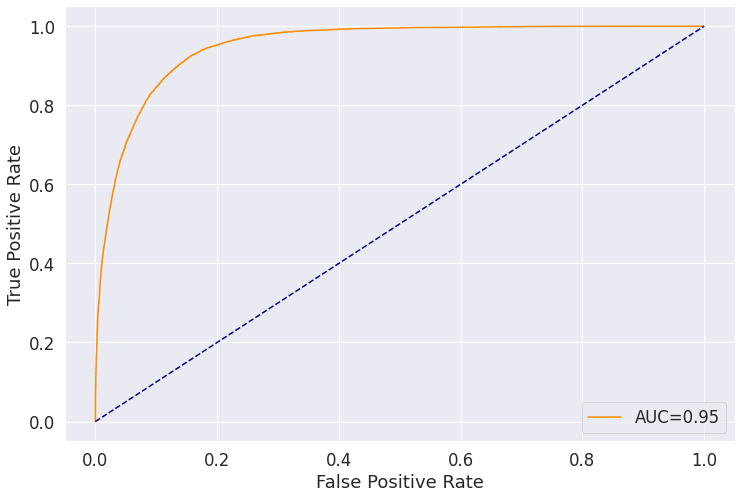

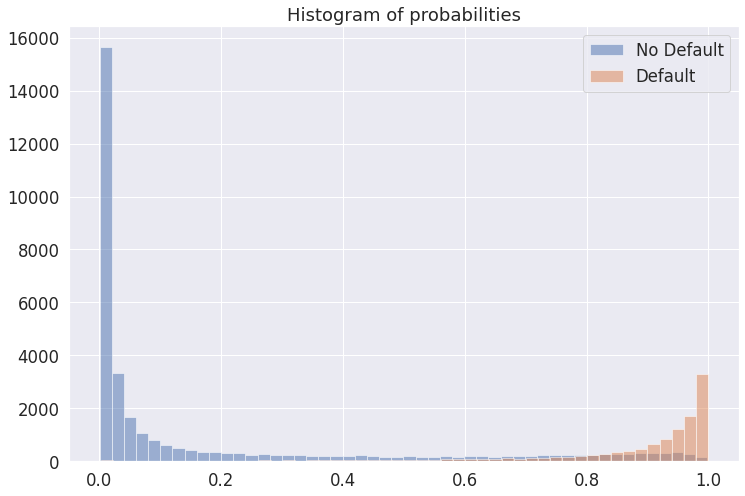

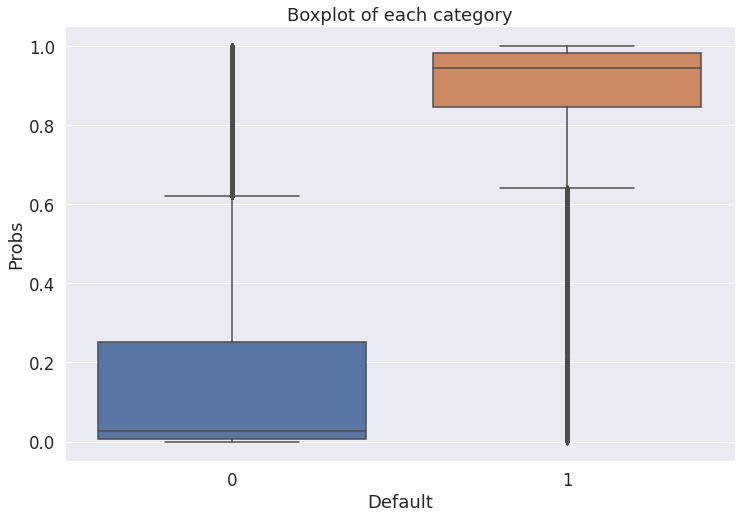

In [ ]:
mod_perforance(y_test, mod2.predict_proba(X_test)[:,1])

In [ ]:
joblib.dump(mod2, "xgb_mod2.sav")

['xgb_mod2.sav']

# Model 2: LightGBM

In [ ]:
model3 = lgb.LGBMClassifier(learning_rate = 0.3, max_depth = -12, random_state = 42, n_estimators = 200,
          gamma = 10 , scale_pos_weight = 4)
model3.fit(X_train, y_train, 
          eval_set = [(X_train, y_train), (X_val, y_val)],
          verbose = 10,
          eval_metric='logloss')

[10]	training's binary_logloss: 0.338533	training's binary_logloss: 0.338533	valid_1's binary_logloss: 0.339432	valid_1's binary_logloss: 0.339432
[20]	training's binary_logloss: 0.322402	training's binary_logloss: 0.322402	valid_1's binary_logloss: 0.325909	valid_1's binary_logloss: 0.325909
[30]	training's binary_logloss: 0.311993	training's binary_logloss: 0.311993	valid_1's binary_logloss: 0.318614	valid_1's binary_logloss: 0.318614
[40]	training's binary_logloss: 0.307863	training's binary_logloss: 0.307863	valid_1's binary_logloss: 0.318981	valid_1's binary_logloss: 0.318981
[50]	training's binary_logloss: 0.31098	training's binary_logloss: 0.31098	valid_1's binary_logloss: 0.333812	valid_1's binary_logloss: 0.333812
[60]	training's binary_logloss: 0.309168	training's binary_logloss: 0.309168	valid_1's binary_logloss: 0.339677	valid_1's binary_logloss: 0.339677
[70]	training's binary_logloss: 0.395145	training's binary_logloss: 0.395145	valid_1's binary_logloss: 0.419957	valid_1'

LGBMClassifier(gamma=10, learning_rate=0.3, max_depth=-12, n_estimators=200,
               random_state=42, scale_pos_weight=4)

Area under the ROC curve : 0.947718


           fpr       tpr     1-fpr        tf  thresholds
4761  0.120597  0.879514  0.879403  0.000111    0.666046

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     34122
           1       0.72      0.88      0.79     11769

    accuracy                           0.88     45891
   macro avg       0.84      0.88      0.85     45891
weighted avg       0.89      0.88      0.88     45891




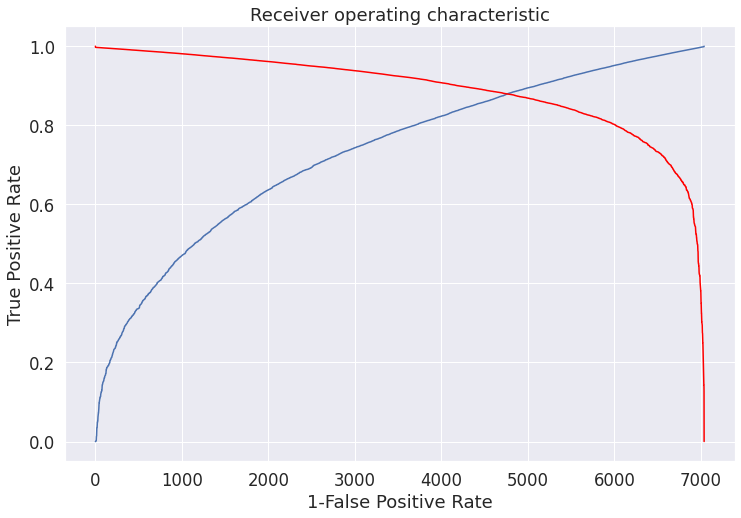

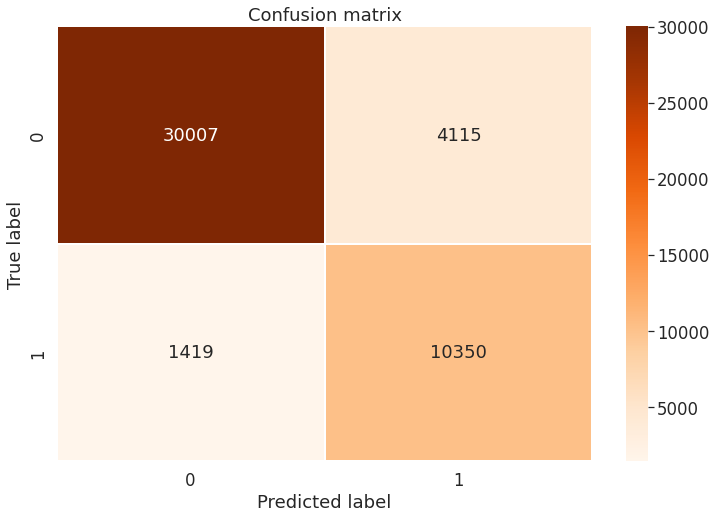

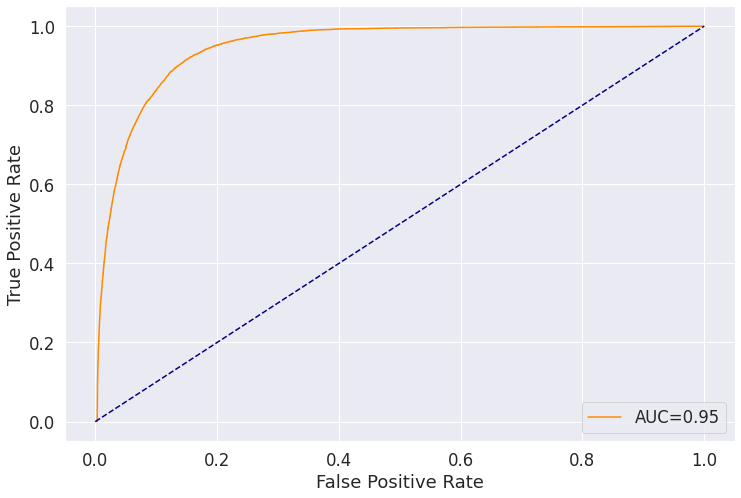

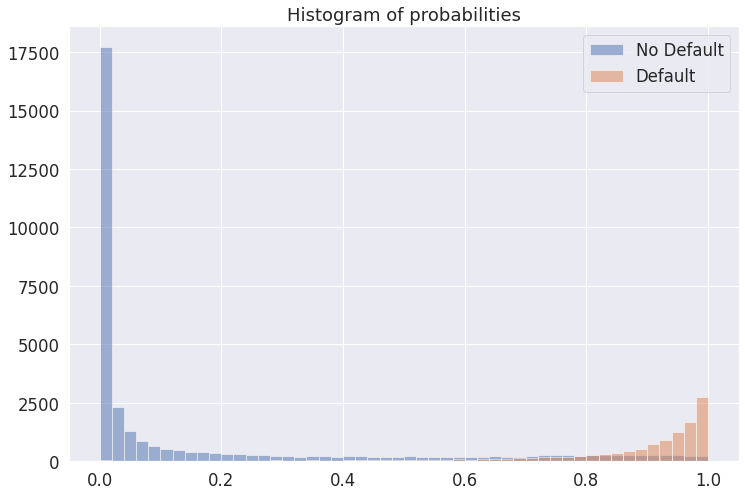

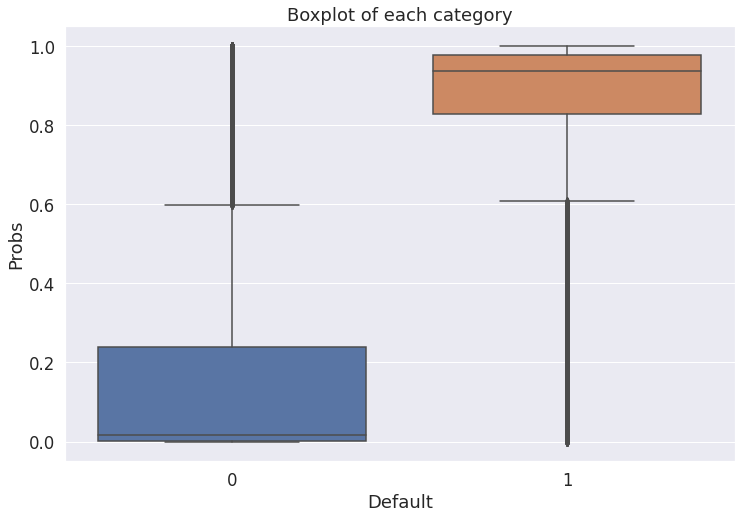

In [ ]:
mod_perforance(y_test, model3.predict_proba(X_test)[:,1])

In [ ]:
joblib.dump(model3, "lgbm_mod3.sav")

['lgbm_mod3.sav']

# Amex Metric

In [ ]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns').sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [ ]:
df_true = pd.DataFrame({'target': y_test})
df_prob = pd.DataFrame({'prediction': mod1.predict_proba(X_test)[:,1]})
df_true.reset_index(drop=True , inplace=True)
df_prob.reset_index(drop=True, inplace=True)
print(amex_metric(df_true, df_prob))

0.745107246098182


In [ ]:
df_true = pd.DataFrame({'target': y_test})
df_prob = pd.DataFrame({'prediction': mod2.predict_proba(X_test)[:,1]})
df_true.reset_index(drop=True , inplace=True)
df_prob.reset_index(drop=True, inplace=True)
print(amex_metric(df_true, df_prob))

0.7457525584110749


In [ ]:
df_true = pd.DataFrame({'target': y_test})
df_prob = pd.DataFrame({'prediction': model3.predict_proba(X_test)[:,1]})
df_true.reset_index(drop=True , inplace=True)
df_prob.reset_index(drop=True, inplace=True)
print(amex_metric(df_true, df_prob))

0.7385904985403564
